<a href="https://colab.research.google.com/github/Cylick-d/A-Two-Stage-Parameter-Efficient-Fine-Tuning-Framework-LoRA-/blob/main/baseline_qwen3b_4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

model：Qwen 2.5 3B (4-bit)
dataset： Databricks Dolly 15k

Step 1：在最前面的 Cell 挂载你的 Google Drive

In [ ]:
from google.colab import drive
import os

# 挂载 Drive 到 /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. 精准指向你的真实项目目录
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT'

# 3. 在项目目录下设定模型输出和数据缓存的路径
OUTPUT_DIR = os.path.join(BASE_DIR, 'experiments', 'qwen-3b-lora-baseline')
DATA_CACHE_DIR = os.path.join(BASE_DIR, 'dataset_cache')
# 设定专门的模型缓存路径
MODEL_CACHE_DIR = os.path.join(BASE_DIR, 'model_cache')

# 创建文件夹（如果不存在的话）
os.makedirs(MODEL_CACHE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

print(f"✅ Drive 挂载成功！")
print(f"📂 模型缓存路径: {MODEL_CACHE_DIR}")
print(f"📂 模型输出路径: {OUTPUT_DIR}")
print(f"📂 数据缓存路径: {DATA_CACHE_DIR}")

✅ Drive 挂载成功！
📂 模型缓存路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/model_cache
📂 模型输出路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/qwen-3b-lora-baseline
📂 数据缓存路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/dataset_cache


In [ ]:
!pip install -q -U transformers peft accelerate datasets trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 51.5 MB/s eta 0:00:00


In [ ]:
!pip install flash-attn

  Using cached flash_attn-2.8.3.tar.gz (8.4 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_dataset
import os
# 数据集

print("⏳ 正在下载并缓存数据集到 Google Drive...")

# 加入 cache_dir 参数，指定下载路径
ds = load_dataset(
    "databricks/databricks-dolly-15k",
    cache_dir=DATA_CACHE_DIR
)

print(f"✅ 数据集下载完毕！已永久保存在: {DATA_CACHE_DIR}")
print(ds) # 打印一下看看数据集的结构

⏳ 正在下载并缓存数据集到 Google Drive...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

✅ 数据集下载完毕！已永久保存在: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/dataset_cache
DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})


In [ ]:
from huggingface_hub import snapshot_download
print(f"⏳ 准备就绪，目标路径: {MODEL_CACHE_DIR}")
print("🚀 开始把 Qwen 2.5 3B 纯模型文件下载到 Google Drive (大概需要几分钟，取决于网速)...")

# 下载操作
# 我们排除掉 .pt 和 .bin 结尾的旧格式文件，只下载最新的 safetensors 格式，帮你省云盘空间
snapshot_download(
    repo_id="Qwen/Qwen2.5-3B",
    cache_dir=MODEL_CACHE_DIR,
    ignore_patterns=["*.pt", "*.bin", "*.msgpack"]
)

print(f"✅ 模型全套文件下载完毕！")

⏳ 准备就绪，目标路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/model_cache
🚀 开始把 Qwen 2.5 3B 纯模型文件下载到 Google Drive (大概需要几分钟，取决于网速)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ 模型全套文件下载完毕！以后重启 Colab 都是秒读！


stander LoRA / L4 GPU/1000 steps 平均 step time: 稳定在 2.1 - 2.2 秒 左右（使用 SDPA 提速后）/Max VRAM Allocated / Reserved: 大约 8.0 GB / 22.5 GB

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # TrainingArguments,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer,SFTConfig
import time

# ==========================================
# 1. 确认模型加载 (4-bit, 关掉 Flash Attention)
# ==========================================
model_id = "Qwen/Qwen2.5-3B"

print("🚀 Step 1: Loading model in 4-bit...form drive")

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    cache_dir=MODEL_CACHE_DIR #
)
# Qwen 没有默认 pad_token，需设定
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4"
)

#
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa",#(no flashattention)
    # attn_implementation= "flash_attention_2",
    cache_dir=MODEL_CACHE_DIR
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

# ==========================================
# 2. 挂标准 LoRA (Minimal 版本)
# ==========================================
print("🚀 Step 2: Applying Standard LoRA...")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ==========================================
# 3. 数据集准备
# ==========================================
print("🚀 Step 3: Loading Dolly 15k subset...")
# 使用你在上一步配置好的 DATA_CACHE_DIR
dataset = load_dataset(
    "databricks/databricks-dolly-15k",
    split="train[:5000]",
    cache_dir=DATA_CACHE_DIR
)

def format_dolly(example):
    instruction = example['instruction']
    context = example.get('context', '')
    response = example['response']

    if context:
        prompt = f"Instruction:\n{instruction}\n\nContext:\n{context}\n\nResponse:\n{response}"
    else:
        prompt = f"Instruction:\n{instruction}\n\nResponse:\n{response}"
    return prompt

# ==========================================
# 4. 显存与吞吐监控探针 & 训练参数
# ==========================================
class BenchmarkCallback(TrainerCallback):
    def __init__(self):
        self.start_time = 0

    def on_step_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_step_end(self, args, state, control, **kwargs):
        step_time = time.time() - self.start_time
        max_alloc = torch.cuda.max_memory_allocated() / (1024**3)
        max_reser = torch.cuda.max_memory_reserved() / (1024**3)

        # 为了前 10 步看清楚，设为每 2 步打印一次
        if state.global_step % 2 == 0:
            print(f"\n--- Step {state.global_step} ---")
            print(f"Step Time: {step_time:.4f} sec")
            print(f"Max VRAM Allocated: {max_alloc:.2f} GB")
            print(f"Max VRAM Reserved:  {max_reser:.2f} GB")

training_args = SFTConfig(
    output_dir=OUTPUT_DIR, # 指向你配置好的 OUTPUT_DIR
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    max_steps=1000,          # 🌟 任务升级：跑满 1000 步！
    save_steps=200,          # 🌟 每 200 步往云盘存一个 Checkpoint 防断连
    logging_steps=50,         # 🌟 每 50 步打印一次 Loss，保持控制台清爽
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    report_to="none",
    max_length=512 # 🌟 max_seq_length 搬到这里来了！
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    # peft_config=lora_config,
    formatting_func=format_dolly,
    processing_class=tokenizer, # 🌟 终极修复：把 tokenizer 改成了 processing_class
    args=training_args,
    callbacks=[BenchmarkCallback()]
)

print("🚀 启动 Day 2 终极测试：完整 1000 Steps Baseline 训练...")
trainer.train()

# ==========================================
# 5. 训练结束，强制保存最终权重！
# ==========================================
print(f"✅ 训练完成！正在将最终 LoRA 权重保存至云盘: {OUTPUT_DIR}")
trainer.save_model(OUTPUT_DIR) # 保存最终的 adapter_model.safetensors
tokenizer.save_pretrained(OUTPUT_DIR) # 顺手把分词器配置也存一份
print("🎉 Baseline 彻底构建完毕！")

🚀 Step 1: Loading model in 4-bit...form drive


Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

🚀 Step 2: Applying Standard LoRA...
trainable params: 3,686,400 || all params: 3,089,625,088 || trainable%: 0.1193
🚀 Step 3: Loading Dolly 15k subset...


Applying formatting function to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


🚀 启动 Day 2 终极测试：完整 1000 Steps Baseline 训练...


Step,Training Loss
50,1.930841
100,1.812759
150,1.790208
200,1.799840
250,1.819141
300,1.847332
350,1.759993
400,1.781758
450,1.785805
500,1.758874



--- Step 2 ---
Step Time: 1.7393 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.19 GB

--- Step 4 ---
Step Time: 1.7457 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.19 GB

--- Step 6 ---
Step Time: 1.6173 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 8 ---
Step Time: 0.9500 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 10 ---
Step Time: 1.6382 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 12 ---
Step Time: 1.2736 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 14 ---
Step Time: 1.9574 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 16 ---
Step Time: 1.4002 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 18 ---
Step Time: 1.6008 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 20 ---
Step Time: 1.0554 sec
Max VRAM Allocated: 11.86 GB
Max VRAM Reserved:  14.23 GB

--- Step 22 ---
Step Time: 1.1068

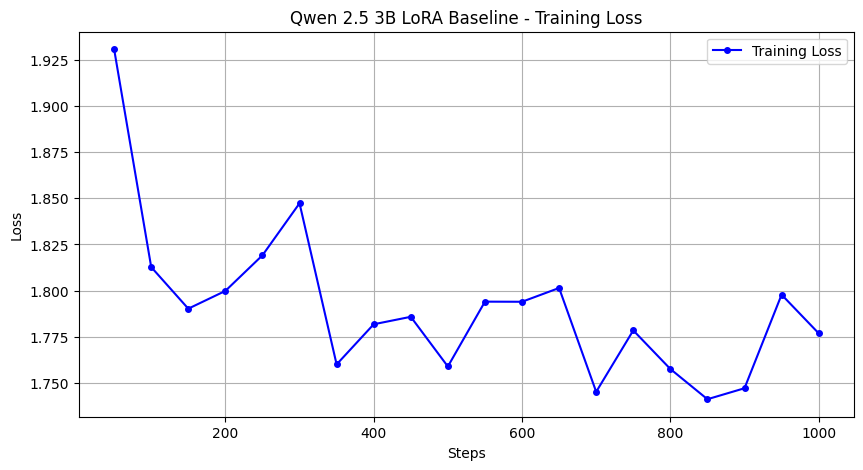

✅ Loss 曲线已保存至: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/qwen-3b-lora-baseline/loss_curve.png


In [ ]:
import json
import matplotlib.pyplot as plt
import os

# 指向你的最终 checkpoint 目录下的 trainer_state.json
log_history_path = os.path.join(OUTPUT_DIR, 'checkpoint-1000', 'trainer_state.json')

with open(log_history_path, 'r') as f:
    data = json.load(f)

# 提取 loss 和 steps
steps = [log['step'] for log in data['log_history'] if 'loss' in log]
losses = [log['loss'] for log in data['log_history'] if 'loss' in log]

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss', color='b', marker='o', markersize=4)
plt.title('Qwen 2.5 3B LoRA Baseline - Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 保存图片到 Drive
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'))
plt.show()

print(f"✅ Loss 曲线已保存至: {os.path.join(OUTPUT_DIR, 'loss_curve.png')}")